In [1]:
#Ref: https://github.com/facebookresearch/mixup-cifar10/blob/master/train.py

In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

from efficientnet_pytorch import EfficientNet
from sklearn.metrics import classification_report, accuracy_score
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Prepare data

In [16]:
def get_dataset(model_name="b0"):
    resolution = EfficientNet.get_image_size("efficientnet-" + model_name)
    tfms = transforms.Compose([transforms.Resize(resolution),
                               transforms.CenterCrop(resolution), 
                               transforms.ToTensor(), 
#                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                              ])
    cal_tech101 = ImageFolder(
        root = "/home/loc/projects/efficient_net/data/101_ObjectCategories",
        transform = tfms
    )

    train_size = int(0.6 * len(cal_tech101))
    test_size = int(0.2 * len(cal_tech101))
    val_size = len(cal_tech101) - train_size - test_size
    train_data, val_data, test_data = random_split(cal_tech101, [train_size, val_size, test_size])

    return train_data, val_data, test_data

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()
    def reset(self):
        self.val, self.avg, self.sum, self.count = 0, 0, 0, 0
    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
loss_list, accuracy_list = list(), list()
        
def plot_graph():
    plt.figure(figsize=(15, 4))
    plt.subplot(121)
    plt.plot(range(len(loss_list)), loss_list, color="green")
    plt.xticks(range(len(loss_list)))
    plt.ylabel("LOSS")
    plt.xlabel("Recorded after every 1 epoch")
    plt.subplot(122)
    plt.plot(range(len(accuracy_list)), accuracy_list, color="orange")
    plt.xticks(range(len(loss_list)))
    plt.ylabel("ACCURACY")
    plt.xlabel("Recorded after every 1 epoch")
    plt.ylim(0,1)
    plt.show()

## Train & Eval

In [10]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

alpha = 1 
mixup_prob = 0.5

def train(model, train_data, val_data, epochs, batch_size):
    optim = torch.optim.Adam(model.parameters())
    loss_list.clear()
    accuracy_list.clear()
    criterion = nn.CrossEntropyLoss().to(device)
    model.to(device)
    model.train()
    dataloader = DataLoader(train_data, batch_size, shuffle=True)
    loss_meter = AverageMeter()
    
    for epoch in range(epochs):
        t = time.time()
        for batch_idx, (inputs, targets) in enumerate(dataloader):
            r = np.random.rand(1)
            optim.zero_grad()
            if r < mixup_prob:
                if alpha > 0:
                    lam = np.random.beta(alpha, alpha)
                else:
                    lam = 1

                rand_index = torch.randperm(inputs.size()[0]).to(device)
                mixed_inputs = lam * inputs + (1 - lam) * inputs[rand_index, :]
                targets_a, targets_b = targets.to(device), targets[rand_index].to(device)

                # compute output
                output = model(inputs.to(device))
                loss = criterion(output, targets_a) * lam + criterion(output, targets_b) * (1. - lam)
            else:
                output = model(inputs.to(device))
                loss = criterion(output, targets.to(device))
            loss.backward()
            optim.step()
            
        accuracy = evaluate(model, val_data, batch_size)
        accuracy_list.append(accuracy)
        loss_list.append(loss.item())
        exe_time = int(time.time()-t)
        print(f"EPOCH: {epoch:>2}, TRAIN_LOSS: {loss.item():.5f}, VAL_ACCU: {accuracy:.4f}, EXE TIME: {exe_time:>3}s")

In [11]:
def evaluate(model, data, batch_size=32, print_accu=False):  
    model.eval()
    accuracy_meter = AverageMeter()
    dataloader = DataLoader(data, batch_size, shuffle=False)
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(dataloader): 
            outputs = model(inputs.to(device))
            outputs = torch.topk(outputs, k=1).indices.squeeze(0).flatten().cpu().tolist()
            targets = targets.flatten().cpu().tolist()
            accuracy_meter.update(accuracy_score(outputs, targets), len(targets))
    model.train()
    if print_accu:
        percentage = accuracy_meter.avg*100
        print(f"VALIDATE ACCURACY: {percentage:.2f}%")
    else:
        return accuracy_meter.avg

## Training

In [12]:
train_data, val_data, test_data = get_dataset()

model = EfficientNet.from_name("efficientnet-b0", override_params={'num_classes': 101})
epochs = 30
batch_size = 128

In [13]:
train(model, train_data, val_data, epochs, batch_size)

EPOCH:  0, TRAIN_LOSS: 3.81870, VAL_ACCU: 0.0899, EXE TIME:  63s
EPOCH:  1, TRAIN_LOSS: 3.42535, VAL_ACCU: 0.0899, EXE TIME:  59s
EPOCH:  2, TRAIN_LOSS: 3.09090, VAL_ACCU: 0.0115, EXE TIME:  62s
EPOCH:  3, TRAIN_LOSS: 3.00776, VAL_ACCU: 0.0109, EXE TIME:  63s
EPOCH:  4, TRAIN_LOSS: 2.95728, VAL_ACCU: 0.0069, EXE TIME:  59s
EPOCH:  5, TRAIN_LOSS: 3.93370, VAL_ACCU: 0.0069, EXE TIME:  59s
EPOCH:  6, TRAIN_LOSS: 4.36880, VAL_ACCU: 0.0069, EXE TIME:  62s
EPOCH:  7, TRAIN_LOSS: 1.63971, VAL_ACCU: 0.0109, EXE TIME:  64s
EPOCH:  8, TRAIN_LOSS: 5.32419, VAL_ACCU: 0.0662, EXE TIME:  63s
EPOCH:  9, TRAIN_LOSS: 3.20230, VAL_ACCU: 0.1573, EXE TIME:  61s
EPOCH: 10, TRAIN_LOSS: 1.47482, VAL_ACCU: 0.2736, EXE TIME:  60s
EPOCH: 11, TRAIN_LOSS: 0.96961, VAL_ACCU: 0.4222, EXE TIME:  61s
EPOCH: 12, TRAIN_LOSS: 1.63067, VAL_ACCU: 0.5265, EXE TIME:  65s
EPOCH: 13, TRAIN_LOSS: 3.35158, VAL_ACCU: 0.4729, EXE TIME:  58s
EPOCH: 14, TRAIN_LOSS: 1.07445, VAL_ACCU: 0.5132, EXE TIME:  64s
EPOCH: 15, TRAIN_LOSS: 2.

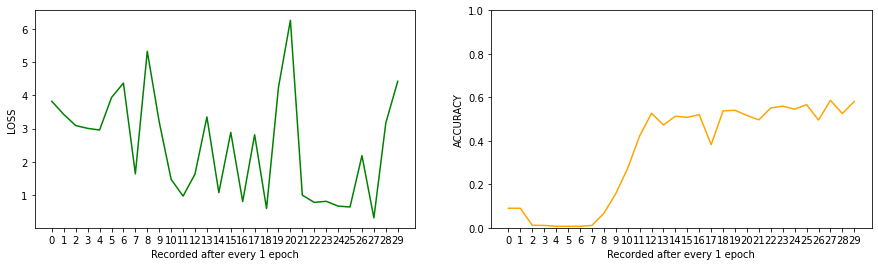

In [14]:
plot_graph()

In [15]:
evaluate(model, test_data, print_accu=True)

VALIDATE ACCURACY: 57.69%


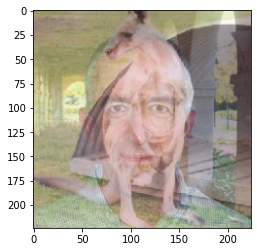

In [26]:
# Visualize
train_data, val_data, test_data = get_dataset()
dataloader = DataLoader(train_data, 10, shuffle=True)

for batch_idx, (inputs, targets) in enumerate(dataloader):
    lam = np.random.beta(alpha, alpha)
    rand_index = torch.randperm(inputs.size()[0]).to(device)
    mixed_inputs = lam * inputs + (1 - lam) * inputs[rand_index, :]
    #Show sample image
    plt.imshow(transforms.functional.to_pil_image(mixed_inputs[0]))
    break